In [ ]:
!nvidia-smi

Tue Mar  2 07:51:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla V100-SXM2-16GB GPUs


In [ ]:
! pip install pytorch-transformers

     |████████████████████████████████| 184kB 14.0MB/s 
     |████████████████████████████████| 133kB 28.3MB/s 
     |████████████████████████████████| 1.2MB 28.0MB/s 
     |████████████████████████████████| 890kB 58.3MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 7.3MB 63.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c1a67ce43020022355296d89448fc39486713921a4d43fc4f0e1518bf311444b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.20.18 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
! pip install transformers

     |████████████████████████████████| 1.9MB 13.8MB/s 
     |████████████████████████████████| 3.2MB 55.4MB/s 


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm
import re

In [ ]:
with open("/content/drive/MyDrive/onti/RuCoS/rucos_train.jsonl", "r") as read_file:
    json_list_train = list(read_file)
train_data = [json.loads(line) for line in json_list_train]

with open("/content/drive/MyDrive/onti/RuCoS/rucos_val.jsonl", "r") as read_file:
    json_list_val = list(read_file)
val_data = [json.loads(line) for line in json_list_val]

with open("/content/drive/MyDrive/onti/RuCoS/rucos_test.jsonl", "r") as read_file:
    json_list_test = list(read_file)
test_data = [json.loads(line) for line in json_list_test]

In [ ]:
def prepare(data):
  prepared_data = []
  entities = []
  querys = []
  labels = []

  for i, sample in enumerate(data):
    context = sample['passage']['text']
    prepared_data.append(context)

    variants = []
    for e in sample['passage']['entities']:
      end = e['end']
      start = e['start']
      variants.append(context[start:end])
    entities.append(tuple(set(variants)))

    querys.append(sample['qas'][0]['query'])

    if 'answers' in sample['qas'][0].keys():
      answers = []
      for answer in sample['qas'][0]['answers']:
        answers.append(answer['text'])
      labels.append(tuple(set(answers)))
  
  return [prepared_data, entities, querys, labels]

In [ ]:
prepare_train_data = prepare(train_data)
prepare_val_data = prepare(val_data)
prepare_test_data = prepare(test_data)

In [ ]:
from transformers import BertTokenizer, BertConfig, AutoTokenizer, AutoModel, AdamW

def create_dataloader(data, batch_size=13):
  # Объединение
  sentences = []
  labels = []
  for minibatch in zip(*data):
    prepared_data, entities, querys, answers = minibatch
    prepared_data = re.sub('@header|@highlight|@context', '', prepared_data)
    context_texts = prepared_data.split('.')
    for ent in entities:
      context = ''
      for text in context_texts:
        if text.find(ent) > 0:
          context += ' ' + text
          
      sub_query = re.sub('@placeholder', '[MASK]', querys)
      sentences.append("[CLS] " + context + sub_query + " [SEP] " + ent)
      labels.append([int(ent in answers)])
  sentences = np.array(sentences)
  labels = np.array(labels)
  
  # Балансировка выборки
  zero_mask = labels[:, 0] == 0
  ones_mask = labels[:, 0] == 1
  sentences_balanced = np.hstack((sentences[ones_mask], sentences[zero_mask][:ones_mask.sum()]))
  labels_balanced = np.vstack((labels[ones_mask], labels[zero_mask][:ones_mask.sum()]))

  # токенезация
  tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence", do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_balanced]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  max_e = 0
  for t in input_ids:
    if len(t) > max_e:
      max_e = len(t)
  print(max_e)
  input_ids = pad_sequences(
      input_ids,
      maxlen=512,
      dtype="long",
      truncating="pre",
      padding="post"
      ) 
  # Получение маски
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  # в тензоры
  train_inputs = torch.tensor(input_ids)
  train_labels = torch.tensor(labels_balanced)
  train_masks = torch.tensor(attention_masks)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  dataloader = DataLoader(
      train_data,
      sampler=RandomSampler(train_data),
      batch_size=batch_size
  )

  return dataloader

In [ ]:
train_dataloader = create_dataloader(prepare_train_data)

318


In [ ]:
validation_dataloader = create_dataloader(prepare_val_data)

284


In [ ]:
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", num_labels=2)
model.to(device)
None

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

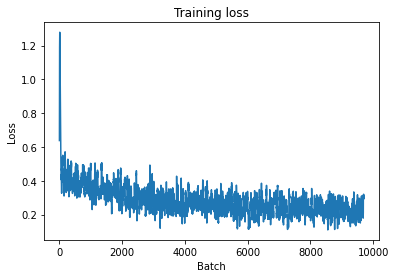

In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step ,batch in enumerate(train_dataloader):
    # if step > 2000:
    #   break
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    if(step+1)%20 == 0:
      # Рисуем график
      clear_output(True)
      smoothing_train_loss_set = double_exponential_smoothing(train_loss_set, 0.1, 0.1)
      plt.plot(smoothing_train_loss_set)
      plt.title("Training loss")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels, valid_logits, valid_labels_2d = [], [], [], []

for step, batch in enumerate(validation_dataloader):
    # if step > 1000:
    #   break   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)

    size_batch = batch_labels.shape[0]
    label_ids_2d = np.zeros((size_batch, 2))
    for i in range(size_batch):
      label_ids_2d[i][batch_labels[i]] = 1

    valid_labels_2d.extend(label_ids_2d) 
    valid_logits.extend(logits)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

In [ ]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))
print()
print("F1 score на валидационной выборке: {0:.2f}%".format(
      f1_score(valid_labels, valid_preds, average='weighted') * 100
      ))
print()
print("roc auc score на валидационной выборке: {0:.2f}%".format(
      roc_auc_score(valid_labels_2d, valid_logits, average='weighted') * 100
))

In [ ]:
sum(valid_preds)

In [ ]:
len(valid_preds)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/onti/ru_bert")

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/onti/ru_bert", num_labels=2)
model.to(device)

In [ ]:
model.eval()
output = []
for step, minibatch in enumerate(tqdm(zip(*prepare_test_data[:-1]))):
  prepared_data, entities, querys = minibatch
  pred_logits = []
  for ent in entities:
      sentence = ("[CLS] " + querys + " [SEP] " + ent + " [SEP]")
      tokenized_text = tokenizer.tokenize(sentence)
      input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
      input_ids = pad_sequences(
          [input_ids, ],
          maxlen=512,
          dtype="long",
          truncating="post",
          padding="post"
      )
      attention_mask = [[float(j>0) for j in input_ids[0]]]

      b_input_ids = torch.tensor(input_ids).to(device)
      b_input_mask = torch.tensor(attention_mask).to(device)
      
      with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          logits = logits[0].detach().cpu().numpy()
          pred_logits.append(logits[0])
  
  n_max_confidence = np.argmax(np.array(pred_logits)[:, 1])
  start = prepared_data.find(entities[n_max_confidence])
  end = start + len(entities[n_max_confidence])
  out_dict = {"idx": step,
              "end": end,
              "start": start,
              "text": entities[n_max_confidence]}
  output.append(out_dict)

with open("/content/drive/MyDrive/onti/out_file.jsonl", "w") as write_file:
  for out in output:
    json.dump(out, write_file, ensure_ascii=False)
    write_file.write('\n')